# Load & Inspect Dataset 

In [3]:
import pandas as pd

# Step 1: Load Lending Club dataset from Downloads
data_path = "/Users/gres1/Downloads/loan_data.csv"
lc_df = pd.read_csv(data_path)

print("Shape:", lc_df.shape)
print(lc_df.head())
print("Columns:", lc_df.columns.tolist())


Shape: (9578, 14)
   credit.policy             purpose  int.rate  installment  log.annual.inc  \
0              1  debt_consolidation    0.1189       829.10       11.350407   
1              1         credit_card    0.1071       228.22       11.082143   
2              1  debt_consolidation    0.1357       366.86       10.373491   
3              1  debt_consolidation    0.1008       162.34       11.350407   
4              1         credit_card    0.1426       102.92       11.299732   

     dti  fico  days.with.cr.line  revol.bal  revol.util  inq.last.6mths  \
0  19.48   737        5639.958333      28854        52.1               0   
1  14.29   707        2760.000000      33623        76.7               0   
2  11.63   682        4710.000000       3511        25.6               1   
3   8.10   712        2699.958333      33667        73.2               1   
4  14.97   667        4066.000000       4740        39.5               0   

   delinq.2yrs  pub.rec  not.fully.paid  
0       

In [4]:
X = lc_df.drop("not.fully.paid", axis=1)
y = lc_df["not.fully.paid"]


# Check for missing values 

In [5]:
# Step 2: Check for missing values
null_counts = lc_df.isnull().sum()
print("Missing values per column:\n", null_counts[null_counts > 0])

# Quick summary: how many total missing?
print("\nTotal missing values:", lc_df.isnull().sum().sum())


Missing values per column:
 Series([], dtype: int64)

Total missing values: 0


In [6]:
# Rebuild feature/target split if needed
X = lc_df.drop("not.fully.paid", axis=1)
y = lc_df["not.fully.paid"]

# Identify columns
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]
print("Categorical:", cat_cols)
print("Numeric:", len(num_cols))


Categorical: ['purpose']
Numeric: 12


# Check Target Distribution 

Counts:
 not.fully.paid
0    8045
1    1533
Name: count, dtype: int64

Percentages:
 not.fully.paid
0    83.994571
1    16.005429
Name: proportion, dtype: float64


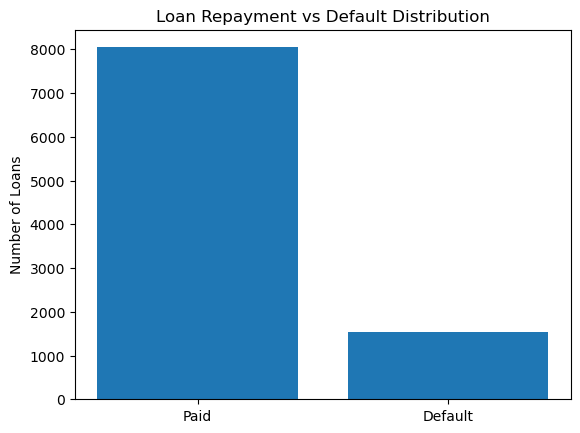

In [7]:
import matplotlib.pyplot as plt

# Step 3: Target distribution
target_counts = lc_df['not.fully.paid'].value_counts(normalize=False)
target_perc = lc_df['not.fully.paid'].value_counts(normalize=True) * 100

print("Counts:\n", target_counts)
print("\nPercentages:\n", target_perc)

# Plot
plt.bar(target_counts.index, target_counts.values, tick_label=["Paid", "Default"])
plt.title("Loan Repayment vs Default Distribution")
plt.ylabel("Number of Loans")
plt.show()


# One Hot Encoding 

In [8]:
from sklearn.preprocessing import OneHotEncoder

# version-safe OneHotEncoder
if "sparse_output" in OneHotEncoder.__init__.__code__.co_varnames:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
else:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False, drop="first")

# fit on categorical columns
X_cat = pd.DataFrame(
    ohe.fit_transform(X[cat_cols]),
    columns=ohe.get_feature_names_out(cat_cols),
    index=X.index
)

# combine numeric + categorical
X_num = X[num_cols].reset_index(drop=True)
X_encoded = pd.concat([X_num, X_cat.reset_index(drop=True)], axis=1)

print("Encoded shape:", X_encoded.shape)


Encoded shape: (9578, 18)


# Handle Imbalance 

In [9]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_encoded, y)

print("Before balancing:\n", y.value_counts())
print("\nAfter balancing:\n", y_resampled.value_counts())


Before balancing:
 not.fully.paid
0    8045
1    1533
Name: count, dtype: int64

After balancing:
 not.fully.paid
0    8045
1    8045
Name: count, dtype: int64


# Plotting Imbalance vs Balance 

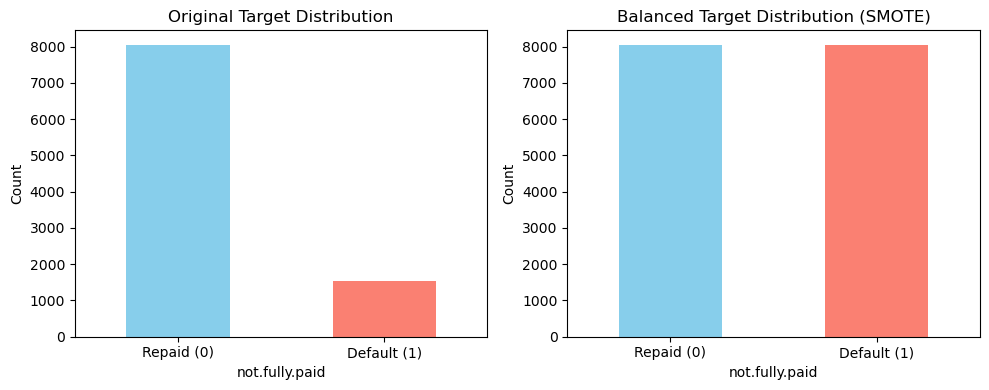

In [10]:
import matplotlib.pyplot as plt

# Before balancing
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
y.value_counts().plot(kind="bar", color=["skyblue","salmon"])
plt.title("Original Target Distribution")
plt.xticks([0,1], ["Repaid (0)", "Default (1)"], rotation=0)
plt.ylabel("Count")

# After balancing
plt.subplot(1,2,2)
y_resampled.value_counts().plot(kind="bar", color=["skyblue","salmon"])
plt.title("Balanced Target Distribution (SMOTE)")
plt.xticks([0,1], ["Repaid (0)", "Default (1)"], rotation=0)
plt.ylabel("Count")

plt.tight_layout()
plt.show()



# Train/Test Split 

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)


Train shape: (12872, 18) | Test shape: (3218, 18)


# Scale Features

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import recall_score, precision_score, roc_auc_score

# Simple NN
clf = MLPClassifier(
    hidden_layer_sizes=(16,),   # small hidden layer
    activation="relu",
    solver="adam",
    batch_size=128,
    max_iter=20,
    early_stopping=True,
    n_iter_no_change=3,
    random_state=42
)

# Train
clf.fit(X_train_scaled, y_train)

# Predictions
y_prob = clf.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

# Metrics
print("Sensitivity (Recall):", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


Sensitivity (Recall): 0.6967060285891858
Precision: 0.7379855167873601
ROC AUC: 0.8054371753665001


/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


# ROC-AUC + ROC Curve

ROC AUC: 0.8054


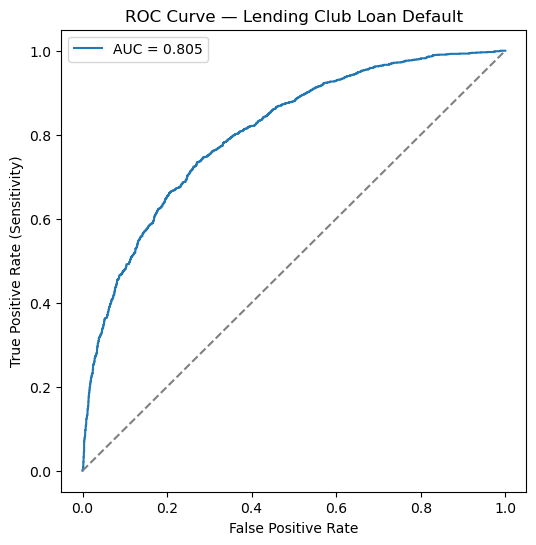

Best threshold (Youden J): 0.4777


In [14]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# AUC score
auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC: {auc:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve — Lending Club Loan Default")
plt.legend()
plt.show()

# Best threshold using Youden's J
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_thr = thresholds[best_idx]
print(f"Best threshold (Youden J): {best_thr:.4f}")
